In [1]:
import os
import torch
# import numpy as np
import matplotlib.pyplot as plt
import torchio as tio
import torchvision
from trainer_lit import LitTrainer
from generator import GeneratorRRDB
from discriminator import Discriminator
from feature_extractor import FeatureExtractor
import pytorch_lightning as pl
from torch.utils.data import DataLoader

from dataset_tio import ImagePair, data_split, Normalize, calculate_overlap

print(os.getcwd())
torch.cuda.empty_cache()

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

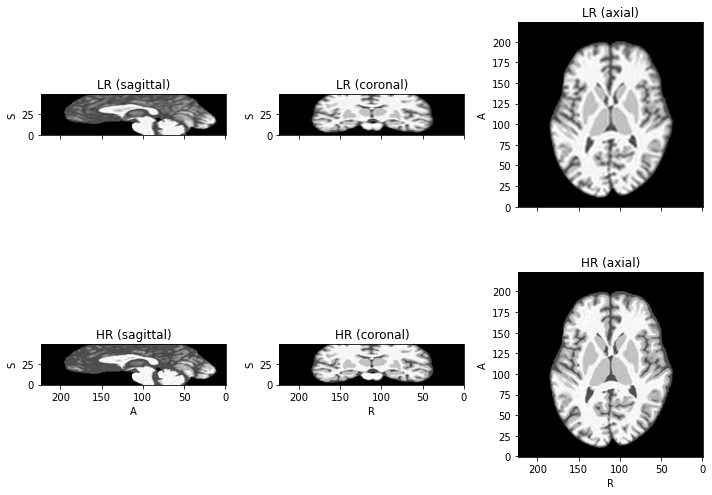

In [3]:
num = 100206
img = ImagePair(number=num, root_dir='data')
# img_slice = img.subject()['LR'].numpy()[0,:,:,25]
# plt.imshow(img_slice, cmap='gray')

img.subject().plot(figsize=(10,10))

In [4]:
train_subjects = data_split('training')
val_subjects = data_split('validation')

Load validation set	: 100%|███████████████| 30/30 [00:03<00:00,  7.63it/s]                                                             


In [5]:
std = 0.3548

training_transform = tio.Compose([
    Normalize(std=std),
    # tio.RandomNoise(p=0.5),
    # tio.RandomFlip(),
])

training_set = tio.SubjectsDataset(
    train_subjects, transform=training_transform)

val_set = tio.SubjectsDataset(
    val_subjects, transform=None)


In [6]:
batch_size = 32
training_batch_size = batch_size
validation_batch_size = batch_size

num_workers = 10
patch_size = (64,64)
ovl_perc = (.5, .5)
overlap, nr_patches = calculate_overlap(train_subjects[0]['LR'], patch_size, ovl_perc)
samples_per_volume = nr_patches

max_queue_length = samples_per_volume*10
sampler = tio.data.GridSampler(patch_size=(*patch_size,1), patch_overlap=overlap)#, padding_mode=0)

training_queue = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

val_queue = tio.Queue(
    subjects_dataset=val_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    training_queue, batch_size=training_batch_size)

val_loader = torch.utils.data.DataLoader(
    val_queue, batch_size=training_batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 64, 64])


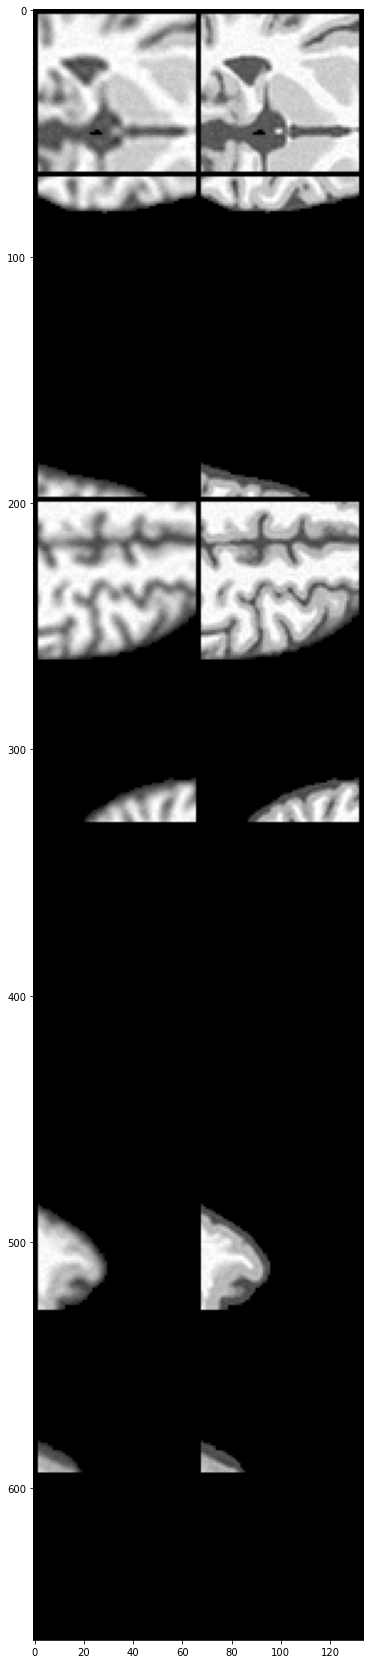

In [7]:
batch = next(iter(training_loader))

lr = batch['LR'][tio.DATA][:10]*std
hr = batch['HR'][tio.DATA][:10]*std

grid = torch.cat([torch.stack([a_row,b_row]) for a_row, b_row in zip(lr.squeeze(),hr.squeeze())]).unsqueeze(1)

print(grid.shape)
grid_img = torchvision.utils.make_grid(grid, nrow=2)

plt.figure(figsize=(10,30))
plt.imshow(grid_img.permute(1, 2, 0))

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1).to(device)
discriminator = Discriminator(input_shape=(1,64,64)).to(device)
feature_extractor = FeatureExtractor().to(device)

In [11]:
model = LitTrainer()
model = model.cuda()
trainer = pl.Trainer(gpus = 1, max_epochs = 10)
trainer.fit(model, train_dataloaders=training_loader)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [9]:
output_dir = 'runs/test_patch'
start_epoch = 1
total_epochs = 10
lambda_edge = 0.5
lambda_pixel = 0.5
lambda_adv = 0
lambda_content = 0
trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    feature_extractor=feature_extractor,
    training_loader=training_loader,
    validation_loader=val_loader,
    start_epoch=start_epoch,
    n_epochs=total_epochs,
    output_dir=output_dir,
    batch_size=batch_size,
    std=std,
    lambda_edge=lambda_edge,
    lambda_pixel=lambda_pixel,
    lambda_adv=lambda_adv,
    lambda_content=lambda_content,
)

metrics = trainer.fit()

Epoch 1


Validation:  45%|██████▊        | 191/422 [08:10<09:52,  2.57s/it, loss_D=0.000, loss_G=0.029]                                         


KeyboardInterrupt: 